### Loading and cleaning data.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [40]:
raw_data = pd.read_csv(
    "../Data/Cars Datasets 2025.csv",
    encoding='ISO-8859-1'
)

raw_data.head(10)

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm
5,BMW,Mclaren 720s,V8,"3,994 cc",710 hp,341 km/h,2.9 sec,"$499,000",Petrol,2,770 Nm
6,ASTON MARTIN,VANTAGE F1,V8,"3,982 cc",656 hp,314 km/h,3.6 sec,"$193,440",Petrol,2,685 Nm
7,BENTLEY,Continental GT Azure,V8,"3,996 cc",550 hp,318 km/h,4.0 sec,"$311,000",Petrol,4,900 Nm
8,LAMBORGHINI,VENENO ROADSTER,V12,"6,498 cc",750 hp,356 km/h,2.9 sec,"$4,500,000",Petrol,2,690 Nm
9,FERRARI,F8 TRIBUTO,V8,"3,900 cc",710 hp,340 km/h,2.9 sec,"$280,000",Petrol,2,770 Nm


In [41]:
# Cleaing Data and removing special carachters
raw_data = raw_data.assign(
    Engines=raw_data['Engines'].str.split('/'),
    **{'CC/Battery Capacity': raw_data['CC/Battery Capacity'].str.split('/')},
    **{'Fuel Types': raw_data['Fuel Types'].str.split('/')},
    HorsePower=raw_data['HorsePower'].str.split('-'),
    **{'Cars Prices': raw_data['Cars Prices'].str.split('-')},
    Torque=raw_data['Torque'].str.split('-')
)

raw_data = (
    raw_data
    .explode('Engines')
    .explode('CC/Battery Capacity')
    .explode('Fuel Types')
    .explode('HorsePower')
    .explode('Cars Prices')
    .explode('Torque')
)

raw_data['Torque'] = raw_data['Torque'].str.split('/')
raw_data['HorsePower'] = raw_data['HorsePower'].str.split('/')
raw_data['CC/Battery Capacity'] = raw_data['CC/Battery Capacity'].str.split('-')

raw_data = raw_data.explode('Torque').explode('HorsePower').explode('CC/Battery Capacity')
raw_data.head()

,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70,165 km/h,10.5 sec,"$12,000",Petrol,5,100
2,Ford,KA+,1.2L Petrol,"1,200 cc",70,165 km/h,10.5 sec,"$12,000",Petrol,5,140 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70,165 km/h,10.5 sec,"$15,000",Petrol,5,100


In [42]:
#Adding Aditional columns
raw_data = raw_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in ['CC/Battery Capacity', 'Fuel Types', 'HorsePower', 'Cars Prices', 'Total Speed','Performance(0 - 100 )KM/H','Torque']:
    raw_data[col + '_capacity'] = raw_data[col].astype(str).apply(lambda x: ' '.join(x.split(' ')[1:]) if isinstance(x, str) and ' ' in x else '')
    raw_data[col] = raw_data[col].astype(str).apply(lambda x: x.split(' ')[0] if isinstance(x, str) and x else x)

    if col == 'Cars Prices':
        raw_data[col] = raw_data[col].astype(str).apply(lambda x: x.replace('$', '').replace(',', '') if isinstance(x, str) else x)

# Eliminar columnas con sufijo _capacity excepto 'CC/Battery Capacity_capacity'
cols_to_drop = [c for c in raw_data.columns if c.endswith('_capacity')]

# Obtaining cleaned dataframe
cleaned_data = raw_data.drop(columns=cols_to_drop)
col_names = [col.lower().replace(' ', '_') for col in cleaned_data.columns]
cleaned_data.columns = col_names

cleaned_data.head()

,company_names,cars_names,engines,cc/battery_capacity,horsepower,total_speed,performance(0_-_100_)km/h,cars_prices,fuel_types,seats,torque
0,FERRARI,SF90 STRADALE,V8,3990,963,340,2.5,1100000,plug,2,800
1,ROLLS ROYCE,PHANTOM,V12,6749,563,250,5.3,460000,Petrol,5,900
2,Ford,KA+,1.2L Petrol,"1,200",70,165,10.5,12000,Petrol,5,100
2,Ford,KA+,1.2L Petrol,"1,200",70,165,10.5,12000,Petrol,5,140
2,Ford,KA+,1.2L Petrol,"1,200",70,165,10.5,15000,Petrol,5,100


In [43]:
cleaned_data.isnull().sum()

company_names                0
cars_names                   0
engines                      0
cc/battery_capacity          0
horsepower                   0
total_speed                  0
performance(0_-_100_)km/h    0
cars_prices                  0
fuel_types                   0
seats                        0
torque                       0
dtype: int64

## Data Preprocessing

> In this section, we will preprocessed our clean dataset to convert some of the most important string variables into integer data types
* Replacing special characters like: [$, ",", " "]
* Transforming columns into integers or floats
* Transforming categorical variables to add more value to the analysis

In [44]:
for col in ['horsepower', 'cars_prices', 'total_speed', 'performance(0_-_100_)km/h','cc/battery_capacity','torque']:

    # 1. Limpieza de strings
    cleaned_data[col] = (
        cleaned_data[col]
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
        .replace('nan', None)
    )

    # 2. Convertir a número
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')

    # 3. Tipos específicos
    if col in ['horsepower', 'cars_prices', 'total_speed', 'torque']:
        cleaned_data[col] = cleaned_data[col].fillna(0).astype(int)

    elif col in ['performance(0_-_100_)km/h']:
        cleaned_data[col] = cleaned_data[col].astype(float)

cleaned_data

,company_names,cars_names,engines,cc/battery_capacity,horsepower,total_speed,performance(0_-_100_)km/h,cars_prices,fuel_types,seats,torque
0,FERRARI,SF90 STRADALE,V8,3990.0,963,340,2.5,1100000,plug,2,800
1,ROLLS ROYCE,PHANTOM,V12,6749.0,563,250,5.3,460000,Petrol,5,900
2,Ford,KA+,1.2L Petrol,1200.0,70,165,10.5,12000,Petrol,5,100
2,Ford,KA+,1.2L Petrol,1200.0,70,165,10.5,12000,Petrol,5,140
2,Ford,KA+,1.2L Petrol,1200.0,70,165,10.5,15000,Petrol,5,100
...,...,...,...,...,...,...,...,...,...,...,...
1216,Toyota,C-HR+,2.0L Hybrid,1987.0,140,180,7.9,0,Hybrid,5,190
1217,Toyota,RAV4 (6th Gen),2.5L Hybrid,2487.0,219,200,6.0,29000,Hybrid,5,221
1217,Toyota,RAV4 (6th Gen),2.5L Hybrid,2487.0,219,200,6.0,29000,Plug-in,5,221
1217,Toyota,RAV4 (6th Gen),Plug-in Hybrid,2487.0,219,200,6.0,29000,Hybrid,5,221


In [45]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2651 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   company_names              2651 non-null   object 
 1   cars_names                 2651 non-null   object 
 2   engines                    2651 non-null   object 
 3   cc/battery_capacity        2632 non-null   float64
 4   horsepower                 2651 non-null   int64  
 5   total_speed                2651 non-null   int64  
 6   performance(0_-_100_)km/h  2641 non-null   float64
 7   cars_prices                2651 non-null   int64  
 8   fuel_types                 2651 non-null   object 
 9   seats                      2651 non-null   object 
 10  torque                     2651 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 248.5+ KB


In [46]:

le = LabelEncoder()
categorical_cols = [col for col in cleaned_data.columns if cleaned_data[col].dtype =='object']

for col in categorical_cols:
    cleaned_data[col] = le.fit_transform(cleaned_data[col].astype(str))

cleaned_data['brand'] = raw_data['Company Names']
cleaned_data['brand_type'] = raw_data['Cars Names']

cleaned_data.head()

,company_names,cars_names,engines,cc/battery_capacity,horsepower,total_speed,performance(0_-_100_)km/h,cars_prices,fuel_types,seats,torque,brand,brand_type
0,8,888,340,3990.0,963,340,2.5,1100000,11,3,800,FERRARI,SF90 STRADALE
1,27,741,333,6749.0,563,250,5.3,460000,8,13,900,ROLLS ROYCE,PHANTOM
2,9,611,21,1200.0,70,165,10.5,12000,8,13,100,Ford,KA+
2,9,611,21,1200.0,70,165,10.5,12000,8,13,140,Ford,KA+
2,9,611,21,1200.0,70,165,10.5,15000,8,13,100,Ford,KA+


## Exploratory Data Analysis

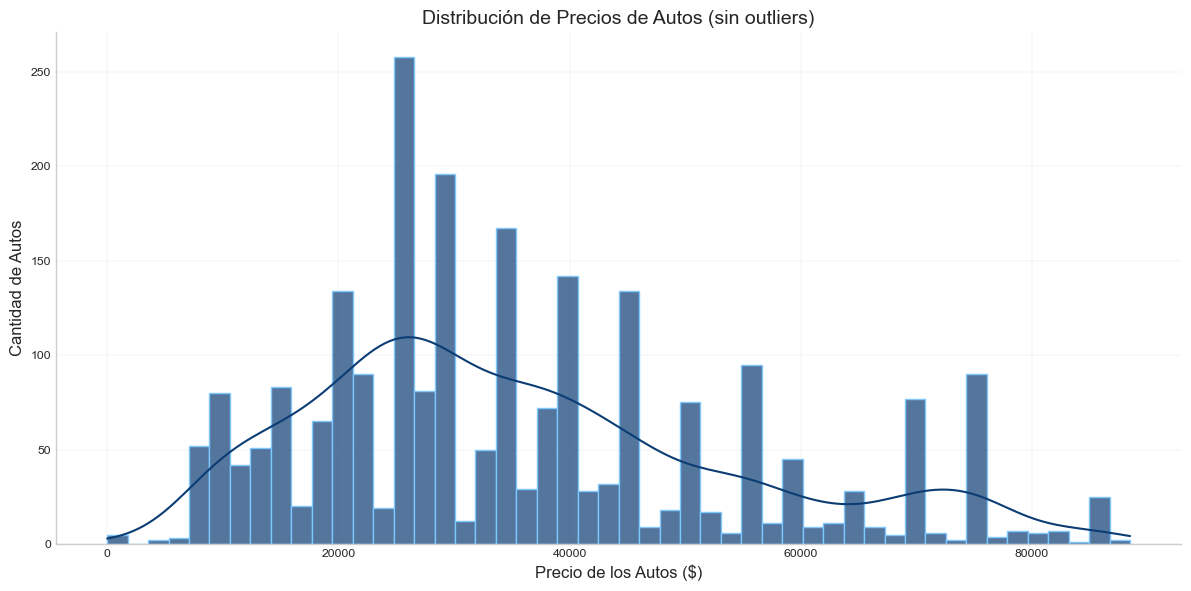

In [47]:
# Checking Target Variable Distributions

plt.style.use("seaborn-v0_8-whitegrid")

# Filtrar valores
data_without_outliers_price = cleaned_data[cleaned_data['cars_prices'] < 90000]

# Crear figura
plt.figure(figsize=(12, 6))

# Histograma con estilo
sns.histplot(
    data=data_without_outliers_price,
    x='cars_prices',
    bins=50,               # Número de bins
    kde=True,              # Mostrar curva de densidad
    color="#0b3c73",       # Color del histograma
    edgecolor="#7ec8ff",   # Bordes de cada barra
    alpha=0.7               # Transparencia
)

# Etiquetas y título
plt.xlabel("Precio de los Autos ($)", fontsize=12)
plt.ylabel("Cantidad de Autos", fontsize=12)
plt.title("Distribución de Precios de Autos (sin outliers)", fontsize=14)

# Mostrar cuadrícula ligera
plt.grid(True, linewidth=0.3, alpha=0.5)

# Quitar bordes superiores y derecho
sns.despine()

plt.tight_layout()
plt.show()


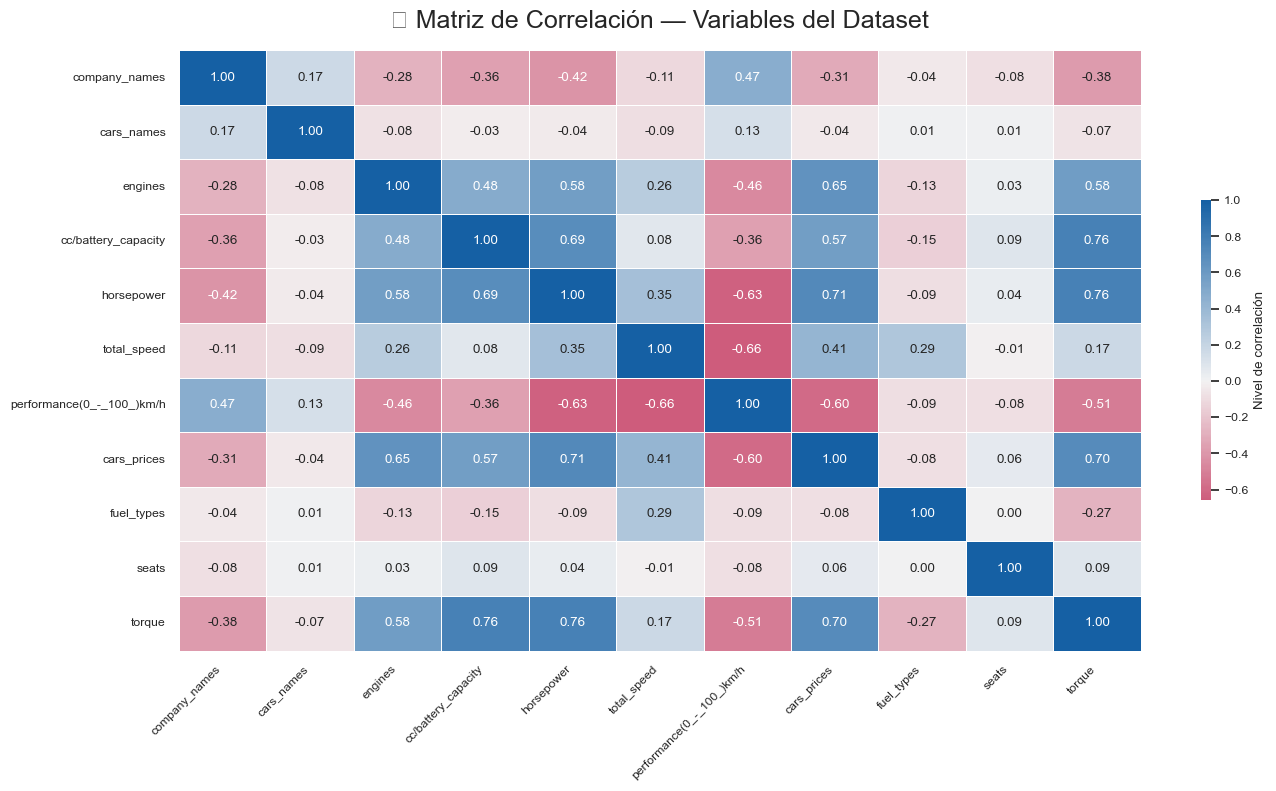

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo moderno
sns.set_theme(style="whitegrid", font_scale=0.8)

# Correlación
corr = data_without_outliers_price.select_dtypes(include =['float','int']).corr()

# Tamaño
plt.figure(figsize=(14, 8))

# Colormap estilizado tipo "coolwarm"
cmap = sns.diverging_palette(5, 250, s=95, l=40, as_cmap=True)



# Heatmap estético
ax = sns.heatmap(
    corr,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    linewidths=0.6,
    linecolor='white',
    cbar_kws={
        'shrink': 0.5,
        'aspect': 30,
        'label': 'Nivel de correlación'
    },
    square=False,
    center=0  # Para que los colores se centren en 0
)

# Estética adicional
plt.title("📊 Matriz de Correlación — Variables del Dataset", fontsize=18, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrar
plt.show()


#### Verifying Correlations

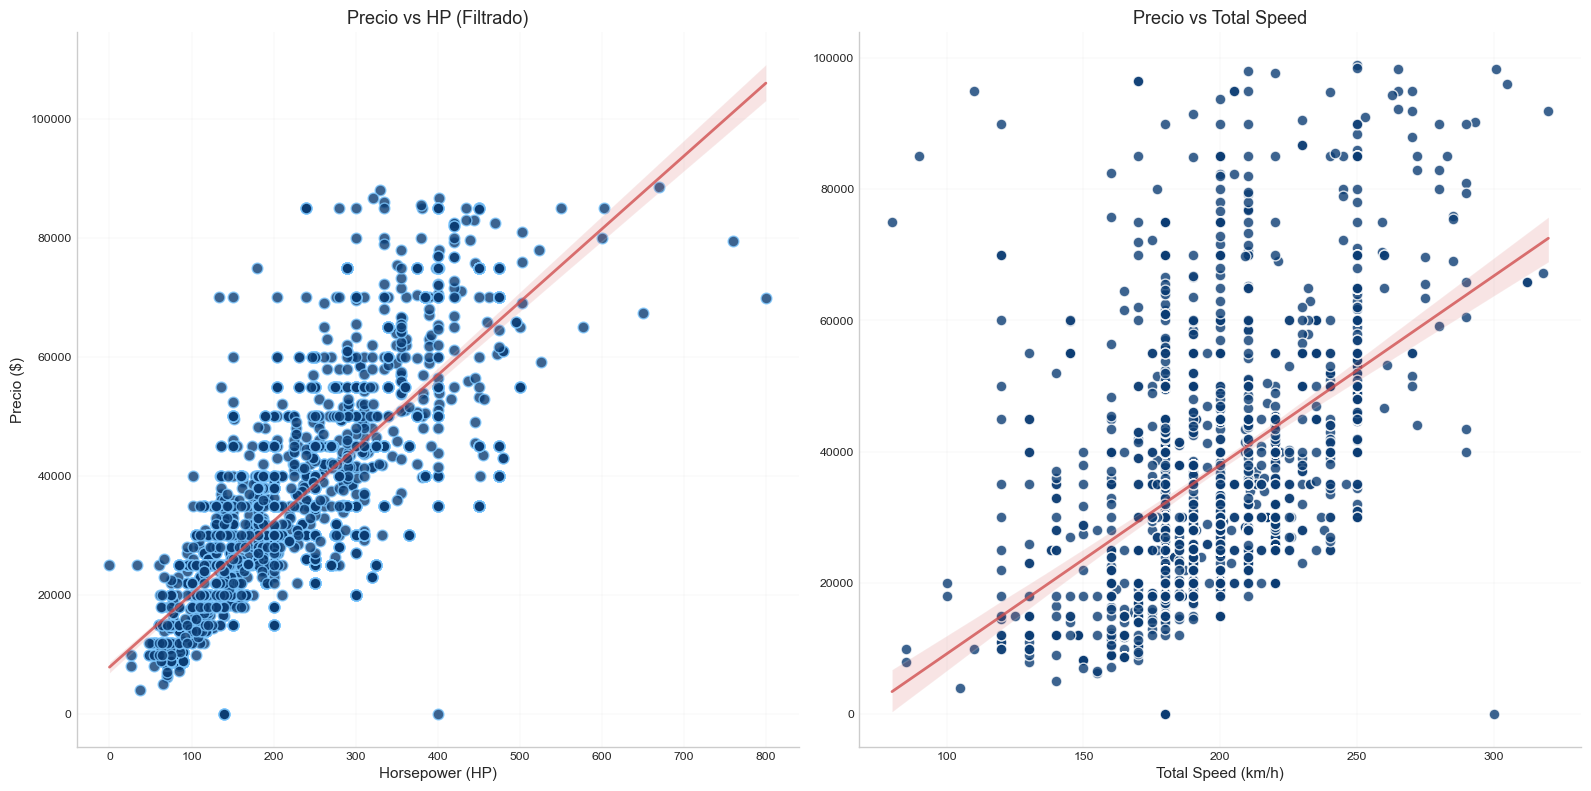

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ---------- GRÁFICO 1: Precio vs HP (Filtrado) ----------
df1 = data_without_outliers_price[
    (data_without_outliers_price['cars_prices'] < 100000) &
    (data_without_outliers_price['horsepower'] < 2000)
]

# Scatter con outline azul cielo
sns.scatterplot(
    data=df1,
    x='horsepower',
    y='cars_prices',
    ax=axes[0],
    s=60,
    alpha=0.8,
    color="#0b3c73",
    edgecolor="#7ec8ff",
    linewidth=1
)

# Línea de tendencia roja
sns.regplot(
    data=df1,
    x='horsepower',
    y='cars_prices',
    scatter=False,
    ax=axes[0],
    color="#d14f4f",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

axes[0].set_title("Precio vs HP (Filtrado)", fontsize=13)
axes[0].set_xlabel("Horsepower (HP)", fontsize=11)
axes[0].set_ylabel("Precio ($)", fontsize=11)
axes[0].grid(True, linewidth=0.3, alpha=0.35)


# ---------- GRÁFICO 2: Precio vs Total Speed ----------
df2 = cleaned_data[
    (cleaned_data['cars_prices'] < 100000)
]

# Scatter sin borde
sns.scatterplot(
    data=df2,
    x='total_speed',
    y='cars_prices',
    ax=axes[1],
    s=60,
    alpha=0.8,
    color="#0b3c73",
    linewidth=1
)

# Línea de tendencia roja
sns.regplot(
    data=df2,
    x='total_speed',
    y='cars_prices',
    scatter=False,
    ax=axes[1],
    color="#d14f4f",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

axes[1].set_title("Precio vs Total Speed", fontsize=13)
axes[1].set_xlabel("Total Speed (km/h)", fontsize=11)
axes[1].set_ylabel("")
axes[1].grid(True, linewidth=0.3, alpha=0.35)


# ---------- ESTÉTICA GLOBAL ----------
sns.despine()
plt.tight_layout()
plt.show()


### Training Model and Evaluation

In [50]:
cleaned_data.columns

Index(['company_names', 'cars_names', 'engines', 'cc/battery_capacity',
       'horsepower', 'total_speed', 'performance(0_-_100_)km/h', 'cars_prices',
       'fuel_types', 'seats', 'torque', 'brand', 'brand_type'],
      dtype='object')

In [51]:
# Spliting training Data

target_var = np.log(data_without_outliers_price['cars_prices'])
inputs = data_without_outliers_price.drop(columns=[ 'brand', 'brand_type'])

scalar = MinMaxScaler()
inputs_scaled = scalar.fit_transform(inputs)
inputs_scaled


array([[0.24242424, 0.50959133, 0.06140351, ..., 0.8       , 0.70588235,
        0.07022472],
       [0.24242424, 0.50959133, 0.06140351, ..., 0.8       , 0.70588235,
        0.09831461],
       [0.24242424, 0.50959133, 0.06140351, ..., 0.8       , 0.70588235,
        0.07022472],
       ...,
       [0.90909091, 0.70225188, 0.4619883 , ..., 1.        , 0.70588235,
        0.15519663],
       [0.90909091, 0.70225188, 0.92397661, ..., 0.6       , 0.70588235,
        0.15519663],
       [0.90909091, 0.70225188, 0.92397661, ..., 1.        , 0.70588235,
        0.15519663]], shape=(2412, 11))

### Splitting into Train and Test sets

In [52]:

x_train, x_test, y_train, y_test = train_test_split(
    inputs_scaled, target_var, test_size=0.2, random_state=42
)

# Reemplazar inf por NaN en DataFrame antes de imputar
x_train = pd.DataFrame(x_train).replace([np.inf, -np.inf], np.nan)
x_test_cleaned = pd.DataFrame(x_test).replace([np.inf, -np.inf], np.nan)

y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)

# Imputar valores faltantes en X
imputer = SimpleImputer(strategy="mean")
x_train_imputed = imputer.fit_transform(x_train)

# Eliminar filas con NaN en y_train
mask = ~y_train.isna()
x_train_clean = x_train_imputed[mask.values]  # usar mask como boolean array
y_train_clean = y_train[mask]

# Entrenar modelo
Model = LinearRegression()
Model.fit(x_train_clean, y_train_clean)
x_train

,0,1,2,3,4,5,6,7,8,9,10
0,0.242424,0.349458,0.649123,0.649294,0.116559,0.504202,0.065421,0.395525,0.2,0.705882,0.280899
1,0.242424,0.349458,0.649123,0.649294,0.180868,0.504202,0.065421,0.395525,0.2,0.705882,0.491573
2,0.272727,0.884904,0.216374,0.193377,0.068328,0.504202,0.199377,0.395525,0.8,0.705882,0.193118
3,0.242424,0.366138,0.008772,0.259621,0.120579,0.588235,0.112150,0.226014,0.8,0.705882,0.105337
4,0.636364,0.712260,0.345029,0.259621,0.059486,0.462185,0.236760,0.282518,0.8,0.705882,0.138343
...,...,...,...,...,...,...,...,...,...,...,...
1924,0.242424,0.349458,0.640351,0.428479,0.116559,0.504202,0.065421,0.395525,0.8,0.705882,0.491573
1925,0.363636,0.497915,0.888889,0.388863,0.100482,0.714286,0.112150,0.678043,0.8,0.705882,0.280899
1926,0.030303,0.703920,0.897661,0.194676,0.109325,0.546218,0.115265,0.621539,0.8,0.705882,0.280899
1927,0.242424,0.362802,0.008772,0.129730,0.034164,0.504202,0.127726,0.169511,0.8,0.705882,0.203652


In [53]:
# Calculating predictions

x_test_imputed = imputer.transform(x_test_cleaned)
predictions = Model.predict(x_test_imputed)
predictions

array([10.15793848,  9.98045166, 10.08028601, 10.63736696, 10.51979306,
       10.69024686, 10.28366204, 10.52126258, 11.43312084,  9.29639131,
       10.2273028 , 10.92276267,  9.74018795, 10.08067198, 10.48855006,
       10.0891352 , 10.5065255 , 10.1255794 , 10.08714591, 11.57979836,
        9.87458492, 10.94051345, 10.35588877, 10.45928109, 11.664332  ,
       10.50842788, 10.42960096, 10.40766706, 10.7846634 ,  9.96085164,
       11.08495133, 10.86038819,  9.89990077, 10.40352139, 10.73840757,
       10.75027682,  9.72415382,  9.74757401,  9.79125124,  9.38243069,
       10.37914471, 11.41020307, 11.01434404, 10.74294763,  9.99836512,
       10.79894131, 10.50358646, 10.88836882,  9.44833985, 10.42192438,
       10.03713695, 10.43008167, 10.01364213,  9.38758167, 10.39886334,
       11.01143327,  9.88158265, 10.22358492,  9.81192851, 10.44644987,
       11.43811548, 10.32688453, 10.13205844, 10.45170877, 10.45351994,
       10.72245163,  9.94995768,  9.92623725, 10.09532044,  9.96

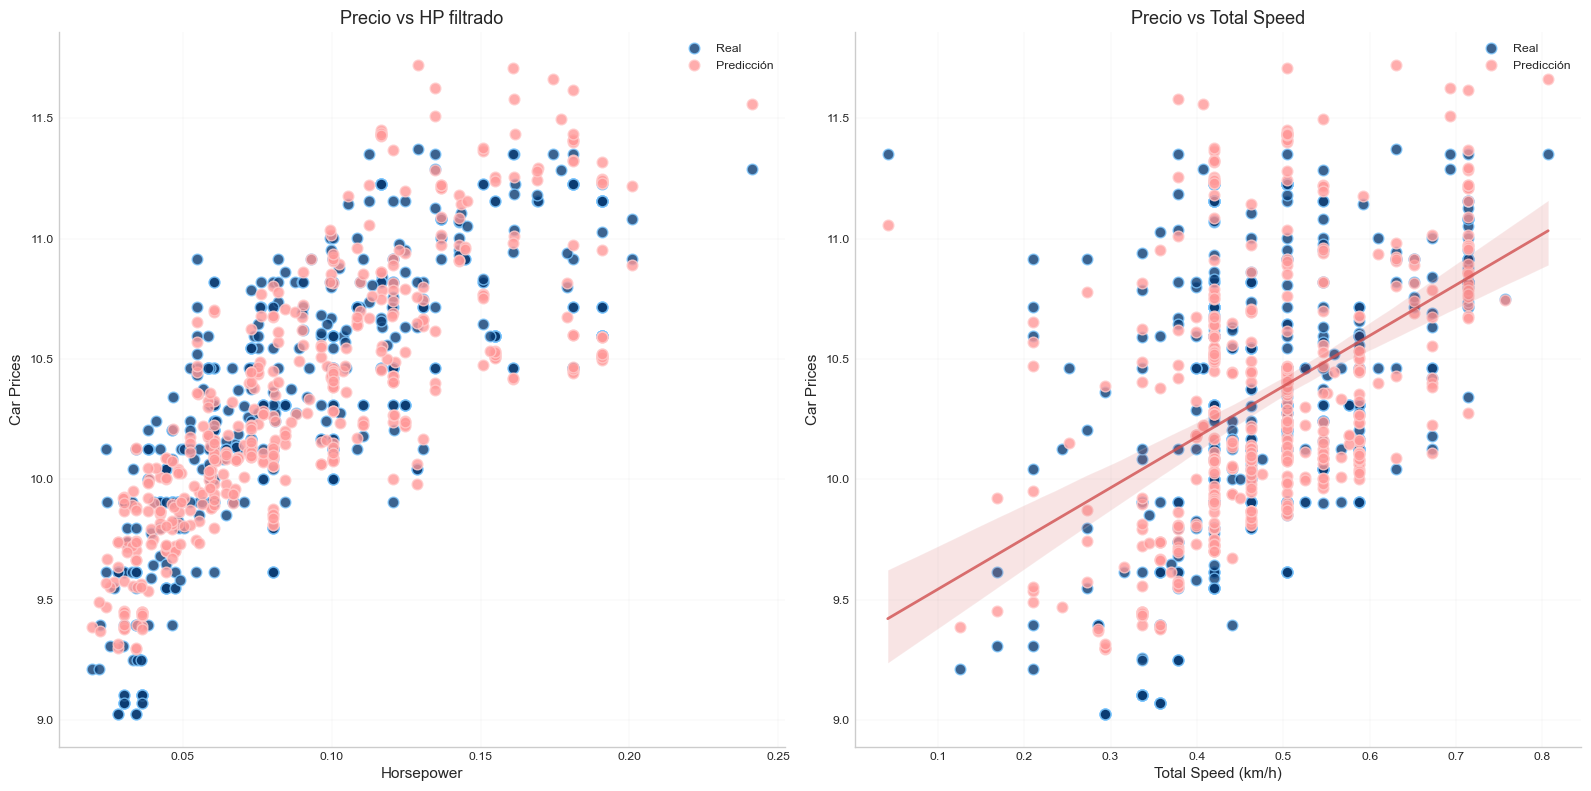

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

# Asegurarse que y_test está alineado
y_test_aligned = y_test.reset_index(drop=True)

# Crear un DataFrame temporal usando x_test_imputed
df_plot = pd.DataFrame({
    'horsepower': x_test_imputed[:, cleaned_data.columns.get_loc('horsepower')],
    'cars_prices': x_test_imputed[:, cleaned_data.columns.get_loc('cars_prices')],
    'total_speed': x_test_imputed[:, cleaned_data.columns.get_loc('total_speed')],
    'predictions': predictions,
    'y_test': y_test_aligned
})

# Filtrado opcional (por ejemplo valores menores a 12)
df1 = df_plot[(df_plot['predictions'] < 12) & (df_plot['y_test'] < 12) & (df_plot['horsepower'] < 0.7)]

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ---------- GRÁFICO 1: Precio vs Horsepower ----------
# Scatter real (azul)
sns.scatterplot(
    data=df1,
    x='horsepower',
    y='y_test',
    s=60,
    alpha=0.8,
    color="#0b3c73",  # azul
    edgecolor="#7ec8ff",
    linewidth=1,
    ax=axes[0],
    label="Real"
)

# Scatter predicciones (rojo claro)
sns.scatterplot(
    data=df1,
    x='horsepower',
    y='predictions',
    s=60,
    alpha=0.8,
    color="#ff9999",  # rojo claro
    edgecolor="#ffcccc",
    linewidth=1,
    ax=axes[0],
    label="Predicción"
)

axes[0].set_title("Precio vs HP filtrado", fontsize=13)
axes[0].set_xlabel("Horsepower", fontsize=11)
axes[0].set_ylabel("Car Prices", fontsize=11)
axes[0].grid(True, linewidth=0.3, alpha=0.35)
axes[0].legend()

# ---------- GRÁFICO 2: Precio vs Total Speed ----------
# Scatter real (azul)
sns.scatterplot(
    data=df1,
    x='total_speed',
    y='y_test',
    s=60,
    alpha=0.8,
    color="#0b3c73",
    edgecolor="#7ec8ff",
    linewidth=1,
    ax=axes[1],
    label="Real"
)

# Scatter predicciones (rojo claro)
sns.scatterplot(
    data=df1,
    x='total_speed',
    y='predictions',
    s=60,
    alpha=0.8,
    color="#ff9999",
    edgecolor="#ffcccc",
    linewidth=1,
    ax=axes[1],
    label="Predicción"
)

# Línea de tendencia para predicciones
sns.regplot(
    data=df1,
    x='total_speed',
    y='predictions',
    scatter=False,
    ax=axes[1],
    color="#d14f4f",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

axes[1].set_title("Precio vs Total Speed", fontsize=13)
axes[1].set_xlabel("Total Speed (km/h)", fontsize=11)
axes[1].set_ylabel("Car Prices", fontsize=11)
axes[1].grid(True, linewidth=0.3, alpha=0.35)
axes[1].legend()

# ---------- ESTÉTICA GLOBAL ----------
sns.despine()
plt.tight_layout()
plt.show()


### Model Evaluation

In [55]:

# Limpiar infinitos en x_test
x_test_cleaned = np.where(np.isinf(x_test_imputed), np.nan, x_test_imputed)

# Limpiar infinitos en y_test
y_test_cleaned = y_test_aligned.replace([np.inf, -np.inf], np.nan)

# Eliminar filas con NaN
mask = ~np.isnan(x_test_cleaned).any(axis=1) & ~y_test_cleaned.isna()
x_test_final = x_test_cleaned[mask]
y_test_final = y_test_cleaned[mask]

# Predicciones sobre datos limpios
y_pred = Model.predict(x_test_final)

# Métricas
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_final, y_pred)

# Coeficientes e intercepto
print("Coeficientes:", Model.coef_)
print("Intercepto:", Model.intercept_)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", np.round(r2, 4))


Coeficientes: [-0.02534822  0.00223819  0.12564398 -0.02015403 -0.28716918 -0.00402618
 -1.27927014  2.1445318   0.02094492 -0.00849125 -0.04117477]
Intercepto: 9.681621516459098
MSE: 0.01970942876406731
RMSE: 0.1403902730393645
R^2: 0.9336
